In [1]:
# variable for whether running on colab or not
running_on_colab = False

In [ ]:
# test commit from colab

In [2]:
# Import drive and connect
if running_on_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    
    import subprocess
    subprocess.run("pip install pyrsgis", shell=True)
    subprocess.run("pip install matplotlib_scalebar", shell=True)

    # Check GPU
    subprocess.run("nvidia-smi", shell=True)

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.model_selection import train_test_split

import dataImageUtils as diu
import plotEvalUtils as peu

import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  0
[]


In [4]:
# constants for program

main_bands = [i+1 for i in range(0,7)]
ndvi_band = 9
labels_band = 8

# choose the input band(s)
input_bands = main_bands
# input_bands = ndvi_band

print('Analyzing bands: ', input_bands)

# store the number of bands, which will be useful for inputting to the neural network later
if input_bands == ndvi_band: nBands = 1
else: nBands = len(main_bands)
print('nBands: ', nBands)

downsampleMajority = False

diu.setGlobalVariables(input_bands, nBands, downsampleMajority)

if running_on_colab: image_base_path = "/content/drive/MyDrive/MangroveClassification/Images/"
else: image_base_path = "../SatelliteImages/"

Analyzing bands:  [1, 2, 3, 4, 5, 6, 7]
nBands:  7



First training image mangroves from labels: 


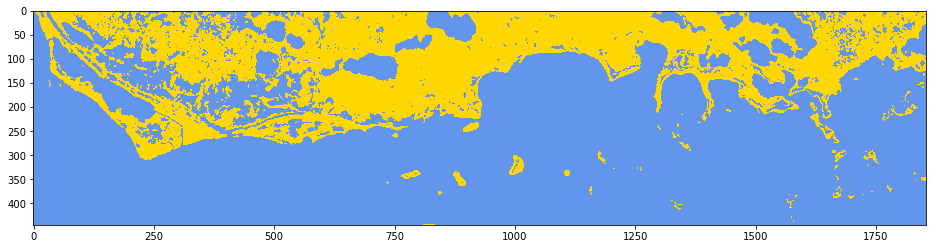

Using training data of length:  2473681
Class 0: 1795361 Class 1: 678320
Class 0:  72.6% Class 1:  27.4%


In [5]:
# generate training data from chosen images
training_images = []
# append images individually so I can test what happens when I mix up the training data - later on will probably want to glob image paths from the source directory
# training_images.append("/content/drive/MyDrive/MangroveClassification/Images/Florida_1_2000.tif")
# training_images.append("/content/drive/MyDrive/MangroveClassification/Images/Florida_3_2000.tif")
# training_images.append("/content/drive/MyDrive/MangroveClassification/Images/Brazil_2_2000.tif")

# training_images.append("../SatelliteImages/Florida_1_2000.tif")
# training_images.append("../SatelliteImages/Florida_3_2000.tif")
# training_images.append("../SatelliteImages/Brazil_2_2000.tif")

training_images.append(image_base_path + "Florida_1_2000.tif")
training_images.append(image_base_path + "Florida_3_2000.tif")
training_images.append(image_base_path + "Brazil_2_2000.tif")


model_input_data, model_input_labels = diu.loadTrainingImages(training_images)

In [6]:
# split the data
xTrain, xTest, yTrain, yTest = train_test_split(model_input_data, model_input_labels, test_size=0.4, random_state=42, stratify=model_input_labels, shuffle=True)

# reshape it as an additional step for input into the NN
xTrain = xTrain.reshape((xTrain.shape[0], 1, nBands))
xTest = xTest.reshape((xTest.shape[0], 1, nBands))

print(xTrain.shape)
print(xTest.shape)


(1484208, 1, 7)
(989473, 1, 7)


In [7]:
# normalize main bands
if input_bands == main_bands:
    xTrain = diu.normalizeUInt16Band(xTrain)
    xTest = diu.normalizeUInt16Band(xTest)

In [8]:
# Define the parameters of the model
if input_bands == ndvi_band:
    model = keras.Sequential([
      keras.layers.Flatten(input_shape=(1, nBands)),
      # keras.layers.Dense(10, activation='relu'),
      keras.layers.Dense(10, activation='relu'),
      keras.layers.Dense(2, activation='softmax')])
else:
    model = keras.Sequential([
      keras.layers.Flatten(input_shape=(1, nBands)),
      keras.layers.Dense(14, activation='relu'),
      keras.layers.Dense(14, activation='relu'),
      keras.layers.Dense(2, activation='softmax')])

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

print(model.summary)

<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fd21bb56130>>


In [9]:
# fit the model
history = model.fit(xTrain, yTrain, validation_split=0.3, epochs=3)

Epoch 1/3
32468/32468 [==============================] - 48s 1ms/step - loss: 8613032817.5464 - accuracy: 0.8799 - val_loss: 0.1931 - val_accuracy: 0.9240
Epoch 2/3
32468/32468 [==============================] - 47s 1ms/step - loss: 0.1928 - accuracy: 0.9240 - val_loss: 0.1890 - val_accuracy: 0.9259
Epoch 3/3
32468/32468 [==============================] - 46s 1ms/step - loss: 114514158.3781 - accuracy: 0.9253 - val_loss: 0.1854 - val_accuracy: 0.9269


In [10]:
print(history.history)

# could make some plots of the metrics/convergance - would want to plot the f1 score though instead of accuracy
# fig, ax = plt.subplots()

# mae = history.history['mae']
# val_mae = history.history['val_mae']

# epochs = range(len(mae))

# ax.plot(epochs, mae, label='Train MAE')
# ax.plot(epochs, val_mae, label='Val MAE')

# ax.legend();

{'loss': [3434811392.0, 0.19266974925994873, 154703360.0], 'accuracy': [0.9077525734901428, 0.9240469932556152, 0.925150990486145], 'val_loss': [0.19305521249771118, 0.18900904059410095, 0.18543754518032074], 'val_accuracy': [0.9239685535430908, 0.9258707761764526, 0.9269285798072815]}


Confusion matrix:
 [[672022  46123]
 [ 25827 245501]]

P-Score: 0.842, R-Score: 0.905
Accuracy: 0.927
f1: 0.872
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95    718145
         1.0       0.84      0.90      0.87    271328

    accuracy                           0.93    989473
   macro avg       0.90      0.92      0.91    989473
weighted avg       0.93      0.93      0.93    989473



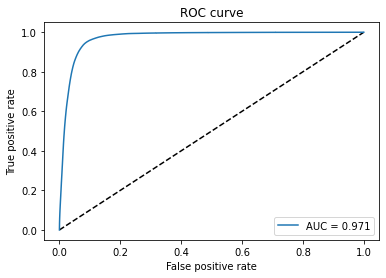

In [11]:
# Predict for test data 
yTest_pred_prob = model.predict(xTest)
yTest_pred_prob = yTest_pred_prob[:,1] # grab probablities for class label 1

peu.printClassificationMetrics(yTest, yTest_pred_prob)
peu.makeROCPlot(yTest, yTest_pred_prob)


Label mangroves from 2000 data:


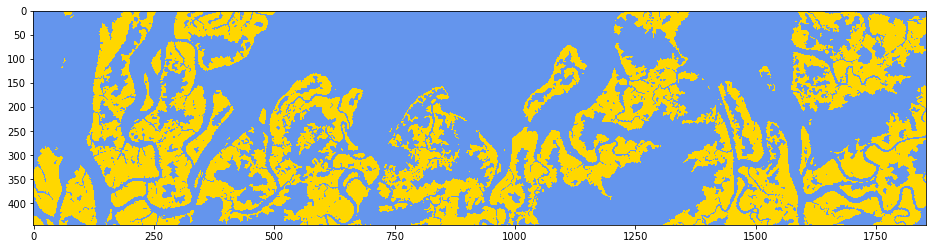

Confusion matrix:
 [[485526  50797]
 [ 43987 245165]]

P-Score: 0.828, R-Score: 0.848
Accuracy: 0.885
f1: 0.838
              precision    recall  f1-score   support

           0       0.92      0.91      0.91    536323
           1       0.83      0.85      0.84    289152

    accuracy                           0.89    825475
   macro avg       0.87      0.88      0.87    825475
weighted avg       0.89      0.89      0.89    825475



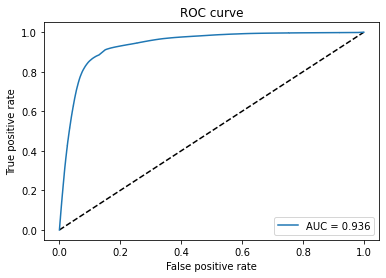


Predicted mangroves:


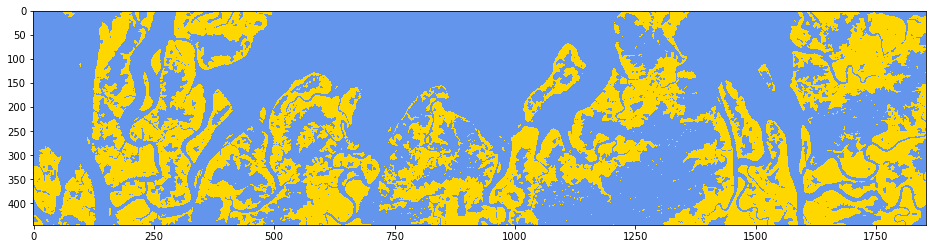


Difference between predicted and labeled mangroves:


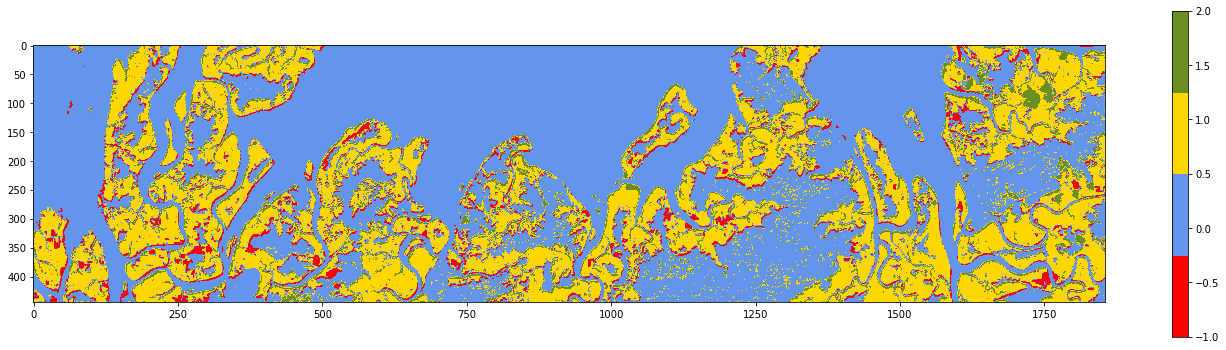

In [12]:
# apply model to new images
# predictOnImage(model, "/content/drive/MyDrive/MangroveClassification/Images/Florida_1_2020.tif")
# predictOnImage(model, "/content/drive/MyDrive/MangroveClassification/Images/Florida_3_2020.tif")
# predictOnImage(model, "/content/drive/MyDrive/MangroveClassification/Images/Brazil_1_2000.tif")

# diu.predictOnImage(model, "../SatelliteImages/Brazil_1_2000.tif")

diu.predictOnImage(model, image_base_path + "Brazil_1_2000.tif")


In [13]:
print('not now timeout!')

not now timeout!
